In [1]:
import solaris as sol
import os
import glob
import gdal
from tqdm import tqdm
import cv2
import shutil
import pandas as pd
import numpy as np

from skimage.morphology import square, dilation
from matplotlib import pyplot as plt
from solaris.eval.iou import calculate_iou
import geopandas as gpd

/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework

## Roadblock while installing the solaris platform

This was set up on Google AI Notebooks (Deep Learning Instance) - TF2.1 
Hardware Config: 4vCPU & 16GB (N2 Instance)
GPU Config: NVidia Tesla P100

Walked through the installation instructions from this page:
https://solaris.readthedocs.io/en/latest/installation.html

### R1
There were some issues with the permission while running the `conda` command
Had some issues with permission to read/write on the following folder 
`/opt/conda/pkgs/cache/ *. json `
and for reading the following folder
`/opt/conda/pkgs`

changed the permissions from root to all users for read & write

### R2
I used the last option defined here to add the solaris environment to the jupyterlab environment. Had to install ipykernel both in base & in the new environment

https://stackoverflow.com/questions/53004311/how-to-add-conda-environment-to-jupyter-lab
https://medium.com/@jeremy.from.earth/multiple-python-kernels-for-jupyter-lab-with-conda-c67e50de3aa3

### R3

Data is downloaded from "Cars Overhead with Context"::
https://gdo152.llnl.gov/cowc/

Command used for http download
`wget -r -np -nH --cut-dirs=4 -R index.html https://gdo152.llnl.gov/cowc/download/cowc/datasets/ground_truth_sets/`

Used the following SF query to construct the above query -
https://stackoverflow.com/questions/23446635/how-to-download-http-directory-with-all-files-and-sub-directories-as-they-appear





In [2]:
# Full path is given here, the relative paths given in the original script were giving an error

root= "/home/jupyter/ground_truth_sets/"  ##cowc ground_truth_sets location after download
masks_out= "/home/jupyter/cowc/masks" ##output location for your masks for training
images_out= "/home/jupyter/cowc/tiles" ##output location for your tiled images for testing
masks_test_out= "/home/jupyter/cowc/masks_test" ##output location for your masks for testing
images_test_out= "/home/jupyter/cowc/tiles_test" ##output location for your tiled images for testing

## Initalizing a tiling function

Below is a function for tiling, solaris presently does not handle non-georeferenced pngs, but will in the future. This is a hold-over function until then.

In [9]:
def geo_tile(untiled_image_dir, tiles_out_dir, tile_size=544,
             overlap=0.2, search=".png",Output_Channels=[1,2,3]):
    """Function to tile a set of images into smaller square chunks with embedded georeferencing info
    allowing an end user to specify the size of the tile, the overlap of each tile, and when to discard
    a tile if it contains blank data.
    Arguments
    ---------
    untiled_image_dir : str
        Directory containing full or partial image strips that are untiled.
        Imagery must be georeferenced.
    tiles_out_dir : str
        Output directory for tiled imagery.
    tile_size : int
        Extent of each tile in both X and Y directions in units of pixels.
        Defaults to ``544`` .
    overlap : float
        The amount of overlap of each tile in float format.  Should range between 0 and <1.
        Defaults to ``0.2`` .
    search : str
        A string with a wildcard to search for files by type
        Defaults to ".png"
    Output_Channels : list
        A list of the number of channels to output, 1 indexed.
        Defaults to ``[1,2,3]`` .
    Returns
    -------
    Tiled imagery directly output to the tiles_out_dir
    """
    if not os.path.exists(tiles_out_dir):
        os.makedirs(tiles_out_dir)

    os.chdir(untiled_image_dir)
    search2 = "*" + search
    images = glob.glob(search2)
    tile_size = int(tile_size)

    for stackclip in images:
        print(stackclip)
        interp = gdal.Open(os.path.abspath(stackclip))
        width = int(interp.RasterXSize)
        height = int(interp.RasterYSize)
        print(width, height)
        count = 0
        for i in range(0, width, int(tile_size * (1 - overlap))):
            for j in range(0, height, int(tile_size * (1 - overlap))):
                Chip = [i, j, tile_size, tile_size]
                count += 1
                Tileout = tiles_out_dir + "/" + \
                    stackclip.split(search)[0] + "_tile_" + str(count) + ".tif"
                output = gdal.Translate(Tileout, stackclip, srcWin=Chip, bandList=Output_Channels)
                del output
    print("Done")

## Organizing the data 

the cowc data is a bit cluttered, so we are re-aranging the data 

In [5]:
#os.chdir('/home/jupyter')
os.chdir(root)
dirs=glob.glob("*/")

Here we re-organize the files into different folders - Images, Masks, & Extras

In [8]:
for directory in dirs:
    os.chdir(directory)
    if not os.path.exists("Images"):
        os.makedirs("Images")
        os.makedirs("Masks")
        os.makedirs("Extras")
    xcfs=glob.glob("*.xcf")
    txts=glob.glob("*.txt")
    #os.chdir("Images") #<< - Commented this out from the original code. No idea why this is required
    #                        Also changed the root paths with full pathnames
    negatives=glob.glob("*Negatives.png")
    masks=glob.glob("*Annotated_Cars.png")
    for xcf in xcfs:
        shutil.move(xcf,os.path.join(root,directory,"Extras",xcf))
    for txt in txts:
        shutil.move(txt,os.path.join(root,directory,"Extras",txt))
    for negative in negatives:
        shutil.move(negative,os.path.join(root,directory,"Extras",negative))
    for mask in masks:
        shutil.move(mask,os.path.join(root,directory,"Masks",mask))
    images=glob.glob("*.png")
    for image in images:
        shutil.move(image,os.path.join(root,directory,"Images",image))
    os.chdir(root)

# Now we will tile our masks & convert them to GeoTiffs

- png converted to tiffs (because solaris works only with GeofTiffs!) 
- Tiling is required for neural n/ws
- So we will tile our masks and images sequentially, this process is time consuming
- We will use the **Utah** tiles for testing 

In [10]:
# Second run, because the notebook timed out,hence removign the directories that were processed 
dirs = dirs[3:]
dirs

['Selwyn_LINZ/', 'Utah_AGRC/', 'Vaihingen_ISPRS/']

In [11]:
# Took more than 4h to complete!!! 
for directory in dirs:
    if directory != "Utah_AGRC":
        directory = os.path.join(root,directory,"Masks")
        print(directory)
        geo_tile(directory, masks_out, tile_size=512, overlap=0.1,search="*.png",Output_Channels=[1])
    else:
        directory = os.path.join(root,directory,"Masks")
        print(directory)
        geo_tile(directory, masks_out, tile_size=512, overlap=0,search="*.png",Output_Channels=[1]) #No overlap for testing.

/home/jupyter/ground_truth_sets/Selwyn_LINZ/Masks
Selwyn_BX22_Tile_LEFT_15cm_0004_Annotated_Cars.png
Selwyn_BX22_Tile_RIGHT_15cm_0001_Annotated_Cars.png
Selwyn_BX22_Tile_RIGHT_15cm_0003_Annotated_Cars.png
Done
/home/jupyter/ground_truth_sets/Utah_AGRC/Masks
12TVL200180_Annotated_Cars.png
12TVL220360-CROP_Annotated_Cars.png
12TVL160660-CROP_Annotated_Cars.png
12TVL220180-CROP_Annotated_Cars.png
12TVK220980-CROP_Annotated_Cars.png
12TVL120100-CROP_Annotated_Cars.png
12TVL180140_Annotated_Cars.png
12TVL160640-CROP_Annotated_Cars.png
12TVL240120_Annotated_Cars.png
Done
/home/jupyter/ground_truth_sets/Vaihingen_ISPRS/Masks
TOP_Mosaic_09cm_scaled_15cm_Gray_Annotated_Cars.png
Done


In [7]:
# Since the kerne had died down. re-starting it from Toronto
dirs = dirs[1:]
dirs

['Toronto_ISPRS/',
 'Columbus_CSUAV_AFRL/',
 'Selwyn_LINZ/',
 'Utah_AGRC/',
 'Vaihingen_ISPRS/']

In [ ]:
%%time

# This takes an inordinate amount of time :: 8h 40min
for directory in tqdm(dirs):
    if directory != "Utah_AGRC":
        directory = os.path.join(root,directory,"Images")
        print(directory)
        geo_tile(directory, images_out, tile_size=512, overlap=0.1,search="*.png",Output_Channels=[1,2,3])
    else:
        directory = os.path.join(root,directory,"Images")
        print(directory)
        geo_tile(directory, images_out, tile_size=512, overlap=0,search="*.png",Output_Channels=[1,2,3])

Here we conduct a morpholigical dilation of the masks 

In [13]:
driver = gdal.GetDriverByName("GTiff")
os.chdir(masks_out)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    band=dilation(band, square(9))
    im_out = driver.Create(image,band.shape[1],band.shape[0],1,gdal.GDT_Byte)
    im_out.GetRasterBand(1).WriteArray(band)
    del im_out

100%|██████████| 11298/11298 [04:16<00:00, 44.01it/s]


CAlculate for z-scoring of images

In [14]:
M1=[]
M2=[]
M3=[]
S1=[]
S2=[]
S3=[]
driver = gdal.GetDriverByName("GTiff")
os.chdir(images_out)
images=glob.glob("*.tif")
for image in images:
    band=gdal.Open(image).ReadAsArray()
    M1.append(np.mean(band[0,:,:]))
    M2.append(np.mean(band[1,:,:]))
    M3.append(np.mean(band[2,:,:]))
    S1.append(np.std(band[0,:,:]))
    S2.append(np.std(band[1,:,:]))
    S3.append(np.std(band[2,:,:]))

print("Save these numbers for your solaris.yml file for training and z-scoring (normalizing) your imagery")
print(np.mean(M1)/255)
print(np.mean(M2)/255)
print(np.mean(M3)/255)
print(np.mean(S1)/255)
print(np.mean(S2)/255)
print(np.mean(S3)/255)

Save these numbers for your solaris.yml file for training and z-scoring (normalizing) your imagery
0.4838757527165056
0.4812117968328578
0.4387958322833492
0.14289727282075199
0.13639378850861267
0.13438871891934995


In [15]:
if not os.path.exists(images_test_out):
        os.makedirs(images_test_out)
os.chdir(images_out)
images = glob.glob("12TVL*")
for image in tqdm(images):
    output = os.path.join(images_test_out,image)
    shutil.move(image, output)

if not os.path.exists(masks_test_out):
        os.makedirs(masks_test_out)
os.chdir(masks_out)
images = glob.glob("12TVL*")
for image in tqdm(images):
    output = os.path.join(masks_test_out,image)
    shutil.move(image, output)

100%|██████████| 4037/4037 [00:00<00:00, 52680.82it/s]


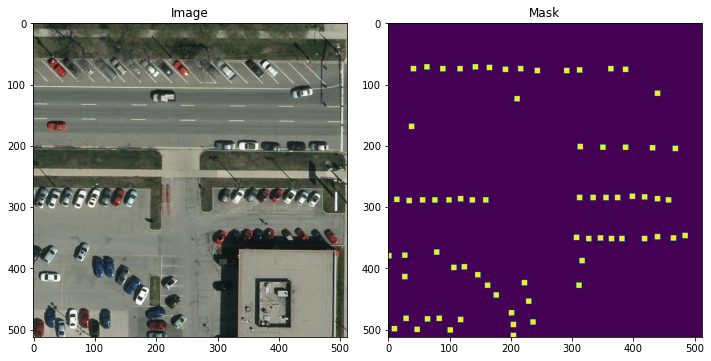

In [25]:
image = os.path.join(images_test_out,"12TVL240120.png_tile_518.tif")
mask = os.path.join(masks_test_out,"12TVL240120_Annotated_Cars.png_tile_518.tif")
image = gdal.Open(image).ReadAsArray()
mask = gdal.Open(mask).ReadAsArray()

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(np.moveaxis(image,0,2))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Mask')
plt.tight_layout()

Create a csv file that lists our images and our masks for training and testing 

In [26]:

data = []
images = []
image_folder=images_out
label_folder=masks_out
os.chdir(label_folder)
labels=glob.glob("*.tif")

In [28]:
len(labels) #Label length list

7261

In [29]:
labels[:5]

['03747_Annotated_Cars.png_tile_54.tif',
 'TOP_Mosaic_09cm_scaled_15cm_Gray_Annotated_Cars.png_tile_337.tif',
 'Selwyn_BX22_Tile_RIGHT_15cm_0001_Annotated_Cars.png_tile_338.tif',
 'Selwyn_BX22_Tile_RIGHT_15cm_0001_Annotated_Cars.png_tile_996.tif',
 'Selwyn_BX22_Tile_RIGHT_15cm_0001_Annotated_Cars.png_tile_106.tif']

In [34]:

for x in tqdm(labels):
    z = x.split('_Annotated_Cars')[0] + x.split('_Annotated_Cars')[1]
    os.chdir(image_folder)
    image=glob.glob(z)
    if len(image) != 1:
        os.chdir(label_folder)
        os.remove(x)        
    else:
        images.append(image[0])
        

100%|██████████| 7261/7261 [00:00<00:00, 127042.33it/s]


In [37]:

for image, label in zip(images,labels):
    image = os.path.join(image_folder,image)
    label = os.path.join(label_folder,label)
    data.append((image, label))

df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv(os.path.join(root,"train_data_cowc2.csv"), index=False)

In [38]:
data = []
images = []
image_folder=images_test_out
label_folder=masks_test_out
os.chdir(label_folder)
labels=glob.glob("*.tif")

In [39]:
for x in labels:
    z = x.split('_Annotated_Cars')[0] + x.split('_Annotated_Cars')[1]
    os.chdir(image_folder)
    image=glob.glob(z)
    if len(image) != 1:
        os.chdir(label_folder)
        os.remove(x)        
    else:
        images.append(image[0])
        
for image, label in zip(images,labels):
    image = os.path.join(image_folder,image)
    label = os.path.join(label_folder,label)
    data.append((image, label))

df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv(os.path.join(root,"test_data_cowc2.csv"))

In [48]:
os.chdir('/home/jupyter')
!git clone https://github.com/jshermeyer/solaris_cowc.git

Cloning into 'solaris_cowc'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 32 (delta 14), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
config = sol.utils.config.parse('/home/jupyter/solaris_cowc/xdxd_vehicleDetection.yml')

## Roadblock 
I get a `IProgress` not available error in the next code block 

`trainer = sol.nets.train.Trainer(config)`

This code block is doing nothing better than downloading the checkpoints

In [6]:
# As suggested in the following SF 
# https://stackoverflow.com/questions/53247985/tqdm-4-28-1-in-jupyter-notebook-intprogress-not-found-please-update-jupyter-an
!conda install -c conda-forge ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Solving environment: done

# All requested packages already installed.

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Roadblock

This didn't solve the error. So I downloaded the VGG16 file from the pytorch model folder and moving it to the required folder

In [ ]:
!wget https://download.pytorch.org/models/vgg16-397923af.pth
!mv vgg16-397923af.pth /home/jupyter/.cache/torch/checkpoints/vgg16-397923af.pth

# Roadblock 
The next error was that the solaris Spacenet model couldn't be downloaded

In [ ]:
trainer = sol.nets.train.Trainer(config)